Goal: Analyzing Comcast Customer Complaints

In [7]:
pyLDAvis.__version__

'3.4.0'

In [4]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# libraries for nlp:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [100]:
#reading in dataset
complaints=pd.read_csv("Comcast_telecom_complaints_data.csv")
complaints.info() # 2224 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Ticket #                     2224 non-null   object
 1   Customer Complaint           2224 non-null   object
 2   Date                         2224 non-null   object
 3   Date_month_year              2224 non-null   object
 4   Time                         2224 non-null   object
 5   Received Via                 2224 non-null   object
 6   City                         2224 non-null   object
 7   State                        2224 non-null   object
 8   Zip code                     2224 non-null   int64 
 9   Status                       2224 non-null   object
 10  Filing on Behalf of Someone  2224 non-null   object
dtypes: int64(1), object(10)
memory usage: 191.2+ KB


In [101]:
complaints.head()

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,05-Jul-15,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
4,307175,Comcast not working and no service to boot,26-05-15,26-May-15,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No


In [102]:
# removing null values
complaints=complaints.dropna()
complaints.shape # no null values present

(2224, 11)

In [103]:
# number of complaints at monthly and daily granularity levels

complaints["Date_month_year"]=pd.to_datetime(complaints["Date_month_year"])
complaints["monthly_level"]=complaints["Date_month_year"].dt.month

complaints["monthly_level"].head() 


C:\Users\skv08\AppData\Local\Temp/ipykernel_18116/3194632988.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  complaints["Date_month_year"]=pd.to_datetime(complaints["Date_month_year"])


0    4
1    8
2    4
3    7
4    5
Name: monthly_level, dtype: int32

In [104]:
monthly_complaints=complaints.groupby("monthly_level").size()
monthly_complaints

monthly_level
1       55
2       59
3       45
4      375
5      317
6     1046
7       49
8       67
9       55
10      53
11      38
12      65
dtype: int64

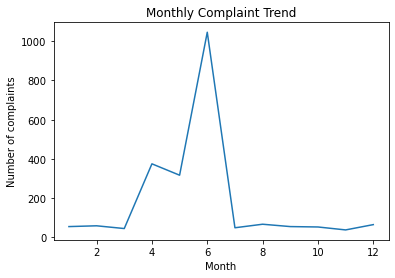

In [105]:
#table with frequency of complaint types
monthly_complaints.plot(kind='line', xlabel='Month', ylabel='Number of complaints', title='Monthly Complaint Trend')
plt.show()

Insight: It seems like there is a sharp rise in complaints from March that peaks at June

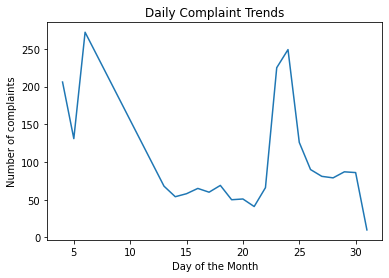

In [106]:
complaints["daily_level"]=complaints["Date_month_year"].dt.day
daily_complaints=complaints.groupby("daily_level").size()

daily_complaints.plot(kind='line', xlabel='Day of the Month', ylabel='Number of complaints', title='Daily Complaint Trends')
plt.show()

It tooks like there are the most complaints around the very beginning and end of the month

Frequency of complaint types


In [107]:
# creating categories of complaints based on key words

#finding keywords among complaints:

#tokenizing the complaints column
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(token)
    return result

complaints['tokens'] = complaints['Customer Complaint'].apply(preprocess)

In [108]:
dictionary = Dictionary(complaints['tokens'])

corpus = [dictionary.doc2bow(doc) for doc in complaints['tokens']]

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)

lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)


Insight from word frequencies:

We see that there are distinct topics of complaints that users talk about, such as topic 4 being about unfair pricing, topic 5 being about slow speeds, and topics 1-3 being about general issues with the words "comcast", "service" etc.
It seems like people are complaining that they were falsely promised a certain standard of quality service that was not delivered, and is too expensive for that customers are getting.

We can see that the maximum complaints are regarding data, internet, service, billing, issues, speeds

In [140]:
#Frequency table:
    
word_freq = {}

for doc in corpus:
    for word_id, freq in doc:
        word = dictionary[word_id]
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1
        

top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10] # top 10 words 

for word, freq in top_words:
    print(f'{word}: {freq}')



comcast: 1244
internet: 531
service: 438
billing: 292
data: 218
speed: 121
xfinity: 103
customer: 93
issues: 90
caps: 78


Insight:

The frequency table also confirms that, as stated previously, it seems like people are complaining that they were falsely promised a certain standard of quality service that was not delivered, and is too expensive for that customers are getting. 

We can see that the maximum complaints are regarding data, internet and customer service, billing, issues, speeds, false advertising etc


Creating a new categorical variable with value as Open and Closed.

Open & Pending is to be categorized as Open and Closed & Solved is to be categorized as Closed.

In [110]:
complaints["Status"].value_counts()

Status
Solved     973
Closed     734
Open       363
Pending    154
Name: count, dtype: int64

In [111]:
def open_closed(status):
    if status=="Open" or status=="Pending":
        status="Open"
    elif status=="Closed" or status=="Solved":
        status="Closed"
    else:
        status="ERROR"
    return status
        
complaints["Status"]=complaints["Status"].apply(open_closed)

In [112]:
complaints["Status"].value_counts()

Status
Closed    1707
Open       517
Name: count, dtype: int64

In [113]:
# statewise status of complaints, with a stacked bar chart

Which state has the maximum complaints?
Which state has the highest percentage of unresolved complaints?


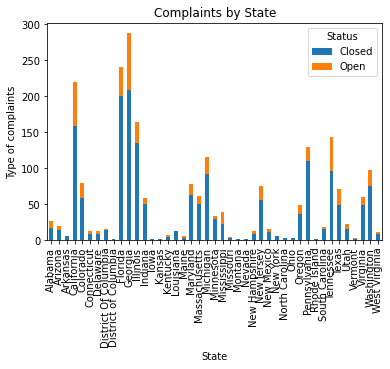

In [114]:
open_closed_complaints=complaints.groupby(["State","Status"])["Status"].size().unstack()

open_closed_complaints.plot(kind='bar',stacked=True,xlabel='State', ylabel='Type of complaints', title='Complaints by State')
plt.show()


Georgia has the most complaints. 

In [116]:
complaints_by_state_status=complaints.groupby(["State","Status"])["Status"].size().unstack()

complaints_by_state_status=complaints_by_state_status.fillna(0)
complaints_by_state_status["Percentage of Unresolved Complaints"]=(complaints_by_state_status["Open"]/(complaints_by_state_status["Closed"]+complaints_by_state_status["Open"]))*100
complaints_by_state_status.sort_values('Percentage of Unresolved Complaints',ascending=False)



Status,Closed,Open,Percentage of Unresolved Complaints
State,,,
Kansas,1.0,1.0,50.000000
Kentucky,4.0,3.0,42.857143
Mississippi,23.0,16.0,41.025641
Maine,3.0,2.0,40.000000
Alabama,17.0,9.0,34.615385
Vermont,2.0,1.0,33.333333
Delaware,8.0,4.0,33.333333
New Hampshire,8.0,4.0,33.333333
Tennessee,96.0,47.0,32.867133



It seems like because Kansas only has 2 records of complaints, one open and one closed, it has the highest percentage of unresolved complaints, at 50%

The percentage of complaints resolved till date, which were received through the Internet and customer care calls.

In [117]:
complaints.head()

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,monthly_level,daily_level,tokens
0,250635,Comcast Cable Internet Speeds,22-04-15,2015-04-22,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No,4,22,"[comcast, cable, internet, speeds]"
1,223441,Payment disappear - service got disconnected,04-08-15,2015-08-04,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,8,4,"[payment, disappear, service, disconnected]"
2,242732,Speed and Service,18-04-15,2015-04-18,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,4,18,"[speed, service]"
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,2015-07-05,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,7,5,"[comcast, imposed, usage, punishes, streaming]"
4,307175,Comcast not working and no service to boot,26-05-15,2015-05-26,1:25:26 PM,Internet,Acworth,Georgia,30101,Closed,No,5,26,"[comcast, working, service, boot]"


In [118]:
complaints["Received Via"].value_counts()

Received Via
Customer Care Call    1119
Internet              1105
Name: count, dtype: int64

In [131]:
complaints_received_through_internet=complaints[complaints["Received Via"]=="Internet"]

complaints_received_through_internet.groupby(["Status"]).size()

Status
Closed    843
Open      262
dtype: int64

In [134]:
#Percentage of internet requests resolved:
complaints_received_through_internet.groupby(["Status"]).size()[0]/(complaints_received_through_internet.groupby(["Status"]).size()[0]+ complaints_received_through_internet.groupby(["Status"]).size()[1]) *100

76.289592760181

In [135]:
#Percentage of customer calls resolved:
complaints_received_through_calls=complaints[complaints["Received Via"]=="Customer Care Call"]
complaints_received_through_calls.groupby(["Status"]).size()[0]/(complaints_received_through_calls.groupby(["Status"]).size()[0]+ complaints_received_through_calls.groupby(["Status"]).size()[1]) *100

77.21179624664879